In [2]:
import warnings
warnings.filterwarnings('ignore')

## API KEY Setting

In [1]:
import os
from config.secret_key import OPENAI_API_KEY, TAVILY_API_KEY

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

## Import Moduels

In [16]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool

from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.messages import SystemMessage, HumanMessage

## Define State

In [3]:
class State(TypedDict):
    messages : Annotated[list, add_messages]

## Define Tools

In [5]:
web_search = TavilySearchResults(max_results=2)

repl = PythonREPL()

@tool
def python_repl(
    code : Annotated[str, "The Python code to execute to generate your chart."]
):
    """
    Use this to execute python code.

    If you want to see the output of a value, you should print it out with 'print(...)'. chart labels should be written in English.

    This is visible to the user.
    """
    # Agent는 tool calling 시 doc string을 참고하기 때문에 가능한 상세히 적어야 함

    try : 
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error : {repr(e)}"
    
    result_str = f"Successfully executed: \n```python\n{code}\n```Stdout: {result}"

    return (
        result_str + "\n\nIf you have completed all tasks, repond with FINAL ANSWER."
    )

tools = [web_search, python_repl]
tool_node = ToolNode(tools)

## Bind Tools with Agent

In [7]:
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def agent(state : State):
    result = llm_with_tools.invoke(state["messages"])
    return {'messages' : [result]}

## Define Conditional edge function

In [9]:
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

## Build Workflow

In [12]:
workflow = StateGraph(State)
memory = MemorySaver()

workflow.add_node("agent", agent)
workflow.add_node("tool", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue" : "tool",
        "end" : END
    }
)

workflow.add_edge("tool", "agent")

graph = workflow.compile(checkpointer=memory, interrupt_before=["tool"])

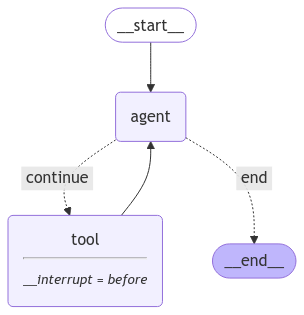

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
initial_input = {'messages' : [HumanMessage(content="미국의 최근 5개년 (~2023) GDP 차트를 그래줄래?")]}
thread = {"configurable" : {"thread_id" : "12"}}

async for chunk in graph.astream(initial_input, thread, stream_mode="updates"): # update 된 state 값만 가져옴져옴
    for node, values in chunk.items():
        print(f"Receving update from node: '{node}")
        print(values)
        print("\n\n")

Receving update from node: 'agent
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6UnbCjIYYIFP1qzL7giWDaVh', 'function': {'arguments': '{"query":"US GDP historical data 2018 to 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 167, 'total_tokens': 196, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-87629387-dbe1-4f00-bf57-209c04143d72-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'US GDP historical data 2018 to 2023'}, 'id': 'call_6UnbCjIYYIFP1qzL7giWDaVh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 167, 'outp

In [18]:
async for chunk in graph.astream(None, thread, stream_mode="updates"): # update 된 state 값만 가져옴져옴
    for node, values in chunk.items():
        print(f"Receving update from node: '{node}")
        print(values)
        print("\n\n")

Receving update from node: 'tool
{'messages': [ToolMessage(content='[{"url": "https://tradingeconomics.com/united-states/gdp", "content": "Interest Rate The Gross Domestic Product (GDP) in the United States was worth 27360.94 billion US dollars in 2023, according to official data from the World Bank. This page provides - United States GDP - actual values, historical data, forecast, chart, statistics, economic calendar and news. GDP GDP GDP Annual Growth Rate GDP Constant Prices GDP Growth Rate Core Inflation Rate MoM Core PCE Price Index MoM Core PCE Price Index YoY Export Prices MoM GDP Price Index Import Prices MoM Inflation Rate MoM PCE Price Index MoM PCE Price Index YoY House Price Index House Price Index MoM House Price Index YoY Economic Calendar Historical Data News Stream Earnings Releases Credit Ratings Forecasts Markets Currencies Stocks Commodities Bonds Crypto Get Started Ratings"}, {"url": "https://tradingeconomics.com/united-states/gdp-growth", "content": "GDP Growth Rat

Python REPL can execute arbitrary code. Use with caution.


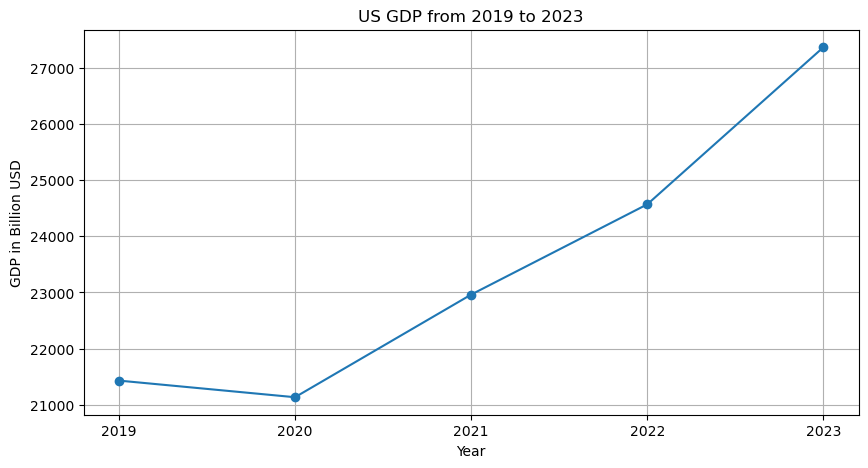

Receving update from node: 'tool
{'messages': [ToolMessage(content="Successfully executed: \n```python\nimport matplotlib.pyplot as plt\nimport numpy as np\n\nyears = np.array([2019, 2020, 2021, 2022, 2023])\nGDP_values = np.array([21433.23, 21137.54, 22962.48, 24567.49, 27360.94])  # in billion USD\n\nplt.figure(figsize=(10, 5))\nplt.plot(years, GDP_values, marker='o')\nplt.title('US GDP from 2019 to 2023')\nplt.xlabel('Year')\nplt.ylabel('GDP in Billion USD')\nplt.xticks(years)\nplt.grid()\nplt.show()\n```Stdout: \n\nIf you have completed all tasks, repond with FINAL ANSWER.", name='python_repl', id='f010650e-1466-4037-ab1d-f134646ff0d9', tool_call_id='call_7zR6CVRMgh4F8uxplksrLlaZ')]}



Receving update from node: 'agent
{'messages': [AIMessage(content='Here is the chart showing the US GDP from 2019 to 2023:\n\n![US GDP from 2019 to 2023](attachment://gdp_chart.png)\n\nThe GDP values are in billion USD, and you can see the trend over these years. If you have any further questions or

In [19]:
async for chunk in graph.astream(None, thread, stream_mode="updates"): # update 된 state 값만 가져옴져옴
    for node, values in chunk.items():
        print(f"Receving update from node: '{node}")
        print(values)
        print("\n\n")